In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# split
from sklearn.model_selection import train_test_split

# column transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing

# encoding
from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer
from category_encoders import OrdinalEncoder
from category_encoders import BinaryEncoder 

# scaling
from sklearn.preprocessing import RobustScaler

# Resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Cross Validation
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_validate

# model Classification
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier         # Untuk Random Forest
from xgboost import XGBClassifier                           # Untuk XGBoost    
import pickle

# scoring classification
from sklearn.metrics import  f1_score, precision_score, recall_score, precision_recall_curve, classification_report, confusion_matrix, RocCurveDisplay

## **Data Cleaning**

In [41]:
df = pd.read_csv('bank-additional-full_cleaned.csv',sep=',')

In [42]:
df


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
30484,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
30485,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
30486,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [43]:
# Mengecek jumlah NaN
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [44]:
# Cek Data Duplikat
df.duplicated().sum()

np.int64(10)

In [45]:
# Hapus Data Duplikat
df.drop_duplicates(inplace=True)

In [46]:
#Ubah value kolom y(Target)
df['y'] = df['y'].map({'no': 0, 'yes': 1}).astype(int)

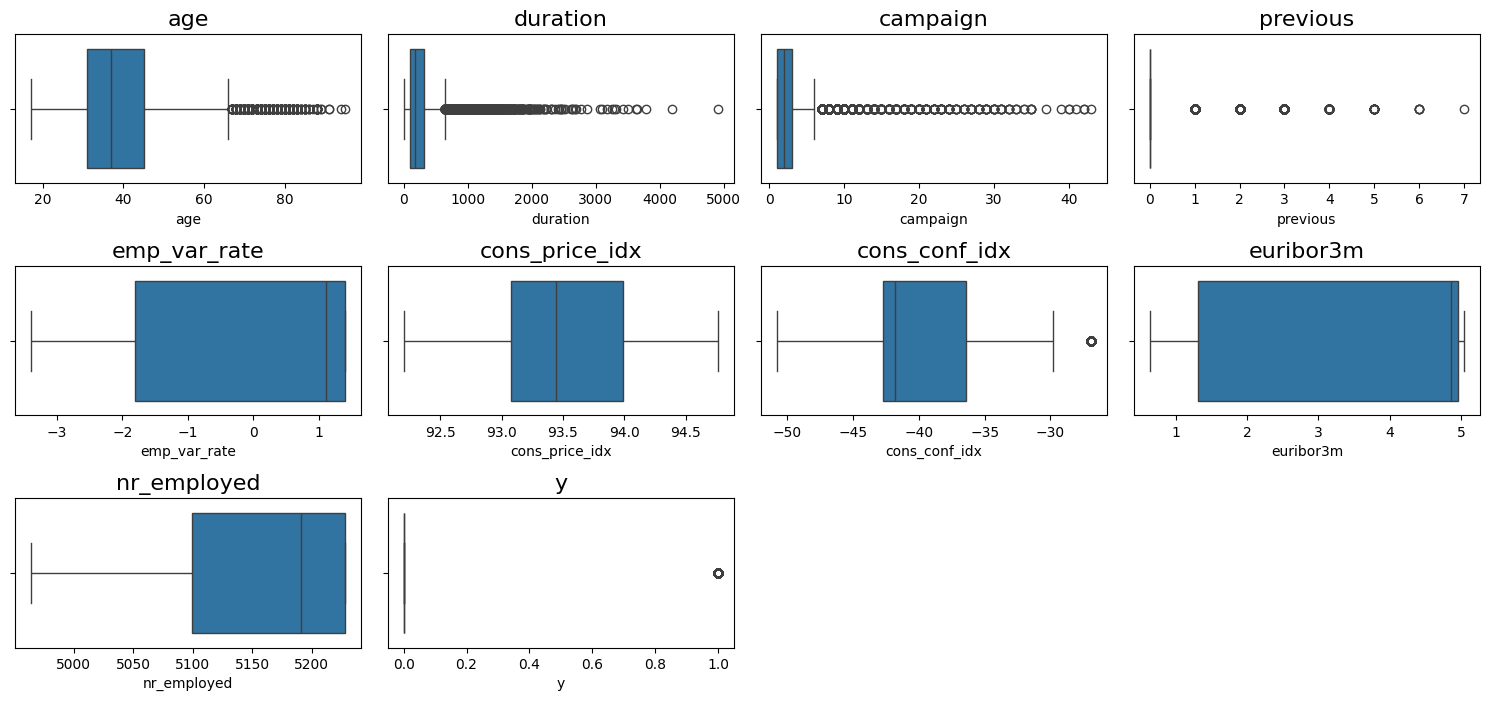

In [47]:
# Cek Outlier
num_feature = df.describe().columns
plt.figure(figsize=(15, 9), facecolor='white')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(4,4, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber = plotnumber + 1

## **Data Preprocessing**

In [48]:
ordinal_mapping = [
    {
        'col': 'education',
        'mapping': {'illiterate': 1, 'basic.4y': 2, 'basic.6y': 3, 'basic.9y': 4, 'high.school':5, 'professional.course':6, 'university.degree': 7}
    }
]

Proses ini bertujuan untuk melakukan ordinal encoding pada fitur `education`, dengan memberikan urutan nilai numerik berdasarkan tingkat pendidikan. Hal ini memungkinkan model machine learning memahami hubungan hierarkis antar kategori, misalnya bahwa university.degree memiliki tingkat lebih tinggi daripada high.school

Fitur Encoding: 
- **Robust Scaler :**  `age`,`campaign`, `emp_var_rate`, `cons_price_idx`, `cons_conf_idx`, `euribor3m`, `nr_employed`,`duration`
- **Onehot Encoder :**  `marital`, `default`, `housing`, `loan`, `contact`, `poutcome`.
- **Binary Encoder:**  `job`, `month`, `day_of_week`
- **Ordinal Encoder:**  `education`,

In [49]:
transformer = ColumnTransformer([
    # Ordinal encoding
    ("ordinal", OrdinalEncoder(cols=["education"], mapping=ordinal_mapping), ["education"]),

    # One-hot encoding
    ("onehot", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
     [ "marital", "default", "housing", "loan", "contact", "poutcome"]),

    # binary encoding
    ("binary", BinaryEncoder(), 
     ["job", "month", "day_of_week"]),

    # Scaling
    ("scaler", RobustScaler(), ["age","campaign", "emp_var_rate", "cons_price_idx", 
                                "cons_conf_idx", "euribor3m", "nr_employed","duration"])
], remainder='passthrough', verbose_feature_names_out=False)

In [50]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal',
                                 OrdinalEncoder(cols=['education'],
                                                mapping=[{'col': 'education',
                                                          'data_type': dtype('O'),
                                                          'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
professional.course    6
university.degree      7
dtype: int64}]),
                                 ['education']),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['marital', 'default', 'housing', 'loan',
                                  'contact', 'poutcome']),
                                ('binary', BinaryEncoder(),
                                 ['job', 'month', 'day_of_week']),
                                ('scaler', RobustScaler(),
                                 ['age', 'campaign', 'emp_var_rate',
                                  'cons_price_idx', 'cons_conf_idx',
                                  'euribor3m', 'nr_employed', 'duration'])],
                  verbose_feature_names_out=False)

## **Modelling and Evaluation**

In [51]:
# Define X and y
X = df.drop(columns=['y'])
y = df['y']

In [52]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split( 
    X, 
    y, 
    test_size=0.2,  
    random_state=42, 
    stratify=y
)

In [53]:
# Mengecek proporsi target
df['y'].value_counts()/len(df['y']) * 100

y
0    87.341689
1    12.658311
Name: count, dtype: float64

In [54]:
# Membuat sebuah variabel untuk teknik sampling
sampling_strategies = {
    'none': None,
    'smote': SMOTE(random_state=42),
    'under_sampling': RandomUnderSampler(random_state=42),
    'smote_tomek': SMOTETomek(random_state=42)
}

### **Cross Validation and Check Perfomance to Data Test**


Proses ini bertujuan untuk mengevaluasi performa model menggunakan teknik cross-validation pada data pelatihan, sekaligus mengukur kinerja akhir model terhadap data pengujian yang belum pernah dilihat sebelumnya. Cross-validation memberikan estimasi performa yang lebih andal dengan membagi data pelatihan ke dalam beberapa fold, sementara evaluasi pada data uji digunakan untuk mengukur generalisasi model secara nyata. Metrik yang digunakan antara lain precision serta metrik bisnis seperti CVR dan ROMI.

Beberapa algoritma klasifikasi disiapkan untuk dievaluasi dan dibandingkan performanya, meliputi model linear dan model berbasis pohon keputusan. Setiap model diinisialisasi dengan parameter default, dan random_state disetel untuk memastikan reprodusibilitas hasil. Model yang digunakan antara lain:

**Logistic Regression :** Dipilih sebagai baseline model karena interpretabilitasnya tinggi dan cepat dilatih. Cocok untuk mengetahui pengaruh fitur secara linier terhadap probabilitas deposit.

**K-Nearest Neighbors :** Dipertimbangkan untuk mengevaluasi pendekatan berbasis kemiripan antara pelanggan. Meskipun kurang efisien pada data besar, KNN berguna sebagai pembanding non-parametrik

**Decision Tree :** Model yang mudah dijelaskan dan menangani fitur kategorikal tanpa perlu banyak preprocessing. Berguna untuk mengeksplorasi hubungan non-linear secara eksplisit.

**Random Forest :** Ensambel tree yang meningkatkan akurasi dan ketahanan terhadap overfitting dibanding single tree. Dapat menangani hubungan kompleks antar fitur dengan baik.

**XGBoost :** Dipilih karena performanya yang unggul dalam berbagai kompetisi dan kasus nyata. Mampu menangani ketidakseimbangan kelas, serta sering menghasilkan precision dan CVR yang tinggi,

Model-model ini akan digunakan dalam proses cross-validation untuk menentukan kandidat terbaik sebelum dilakukan hyperparameter tuning lebih lanjut.

In [55]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
}

In [56]:
# Constants
COST_PER_CALL = 23 
REVENUE_PER_CONVERSION = 500  

def calc_cvr(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    if TP + FP == 0:
        return 0.0
    return (TP / (TP + FP)) * 100

def calc_romi(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    total_revenue = TP * REVENUE_PER_CONVERSION
    total_cost = (TP + FP) * COST_PER_CALL
    if total_cost == 0:
        return 0.0
    return ((total_revenue - total_cost) / total_cost) * 100

# Cross-validation setup
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {  
    'precision': 'precision',
}

results_all_models = []

print("Testing preprocessor...")
try:
    X_sample = X_train.head(100)
    X_transformed = transformer.fit_transform(X_sample, y_train.head(100))
    print(f"\u2713 Transformer works! Transformed shape: {X_transformed.shape}")
except Exception as e:
    print(f"\u2717 Transformer error: {e}")
    import traceback
    traceback.print_exc()

print(f"\nDataset info:")
print(f"Training set shape: {X_train.shape}")
print(f"Target distribution:\n{y_train.value_counts()}")
print(f"Target distribution (%):\n{y_train.value_counts(normalize=True).round(4)}")

for sampling_name, sampling_strategy in sampling_strategies.items():
    print(f"\n{'='*60}")
    print(f"SAMPLING STRATEGY: {sampling_name.upper()}")
    print(f"{'='*60}")

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with {sampling_name}...")

        if sampling_strategy is None:
            pipeline = Pipeline([
                ("preprocessing", transformer),
                ("modeling", model)
            ])
        else:
            pipeline = ImbPipeline([
                ("preprocessing", transformer),
                ("sampling", sampling_strategy),
                ("modeling", model)
            ])

        try:
            X_sample = X_train.head(200)
            y_sample = y_train.head(200)
            pipeline.fit(X_sample, y_sample)
            print(f"  \u2713 Pipeline fit successful")

            cv_results = cross_validate(
                estimator=pipeline,
                X=X_train,
                y=y_train,
                cv=cv_folds,
                scoring=scoring,
                return_train_score=True,
                n_jobs=1
            )

            # Predict test set
            y_pred = pipeline.predict(X_test)
            cvr = calc_cvr(y_test, y_pred)
            romi = calc_romi(y_test, y_pred)

            result = {
                'Sampling': sampling_name,
                'Model': model_name,
                'Train_Precision': cv_results['train_precision'].mean().round(4),
                'Test_Precision': cv_results['test_precision'].mean().round(4),
                'CVR': round(cvr, 2),
                'ROMI': round(romi, 2)
            }
            results_all_models.append(result)

            print(f"  \u2713 {model_name} completed successfully")
            print(f"    - Test Precision: {result['Test_Precision']}")
            print(f"    - CVR: {result['CVR']}%")
            print(f"    - ROMI: {result['ROMI']}%")

        except Exception as e:
            print(f"  \u2717 Error with {model_name}: {str(e)}")
            import traceback
            traceback.print_exc()

            result = {
                'Sampling': sampling_name,
                'Model': model_name,
                'Train_Precision': 0.0,
                'Test_Precision': 0.0,
                'CVR': 0.0,
                'ROMI': 0.0
            }
            results_all_models.append(result)

if results_all_models:
    df_cv_results = pd.DataFrame(results_all_models)
    print("\n" + "=" * 100)
    print("CROSS-VALIDATION RESULTS - ALL COMBINATIONS")
    print("=" * 100)
    print(df_cv_results.to_string(index=False))
else:
    print("No results to display - all models failed.")


Testing preprocessor...
✓ Transformer works! Transformed shape: (100, 28)

Dataset info:
Training set shape: (24382, 19)
Target distribution:
y
0    21296
1     3086
Name: count, dtype: int64
Target distribution (%):
y
0    0.8734
1    0.1266
Name: proportion, dtype: float64

SAMPLING STRATEGY: NONE

Evaluating Logistic Regression with none...
  ✓ Pipeline fit successful


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

  ✓ Logistic Regression completed successfully
    - Test Precision: 0.6704
    - CVR: 49.73%
    - ROMI: 981.12%

Evaluating K-Nearest Neighbors with none...
  ✓ Pipeline fit successful
  ✓ K-Nearest Neighbors completed successfully
    - Test Precision: 0.5881
    - CVR: 53.02%
    - ROMI: 1052.52%

Evaluating Decision Tree with none...
  ✓ Pipeline fit successful
  ✓ Decision Tree completed successfully
    - Test Precision: 0.5124
    - CVR: 45.83%
    - ROMI: 896.38%

Evaluating Random Forest with none...
  ✓ Pipeline fit successful
  ✓ Random Forest completed successfully
    - Test Precision: 0.6644
    - CVR: 52.97%
    - ROMI: 1051.44%

Evaluating XGBoost with none...
  ✓ Pipeline fit successful
  ✓ XGBoost completed successfully
    - Test Precision: 0.6361
    - CVR: 53.02%
    - ROMI: 1052.64%

SAMPLING STRATEGY: SMOTE

Evaluating Logistic Regression with smote...
  ✓ Pipeline fit successful


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

  ✓ Logistic Regression completed successfully
    - Test Precision: 0.4664
    - CVR: 35.97%
    - ROMI: 681.96%

Evaluating K-Nearest Neighbors with smote...
  ✓ Pipeline fit successful
  ✓ K-Nearest Neighbors completed successfully
    - Test Precision: 0.4323
    - CVR: 33.37%
    - ROMI: 625.52%

Evaluating Decision Tree with smote...
  ✓ Pipeline fit successful
  ✓ Decision Tree completed successfully
    - Test Precision: 0.5079
    - CVR: 43.25%
    - ROMI: 840.22%

Evaluating Random Forest with smote...
  ✓ Pipeline fit successful
  ✓ Random Forest completed successfully
    - Test Precision: 0.6114
    - CVR: 45.55%
    - ROMI: 890.16%

Evaluating XGBoost with smote...
  ✓ Pipeline fit successful
  ✓ XGBoost completed successfully
    - Test Precision: 0.621
    - CVR: 44.59%
    - ROMI: 869.28%

SAMPLING STRATEGY: UNDER_SAMPLING

Evaluating Logistic Regression with under_sampling...
  ✓ Pipeline fit successful


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ✓ Logistic Regression completed successfully
    - Test Precision: 0.4565
    - CVR: 38.67%
    - ROMI: 740.7%

Evaluating K-Nearest Neighbors with under_sampling...
  ✓ Pipeline fit successful
  ✓ K-Nearest Neighbors completed successfully
    - Test Precision: 0.4228
    - CVR: 38.25%
    - ROMI: 731.56%

Evaluating Decision Tree with under_sampling...
  ✓ Pipeline fit successful
  ✓ Decision Tree completed successfully
    - Test Precision: 0.4176
    - CVR: 41.4%
    - ROMI: 799.99%

Evaluating Random Forest with under_sampling...
  ✓ Pipeline fit successful
  ✓ Random Forest completed successfully
    - Test Precision: 0.4439
    - CVR: 33.48%
    - ROMI: 627.85%

Evaluating XGBoost with under_sampling...
  ✓ Pipeline fit successful
  ✓ XGBoost completed successfully
    - Test Precision: 0.4567
    - CVR: 34.3%
    - ROMI: 645.75%

SAMPLING STRATEGY: SMOTE_TOMEK

Evaluating Logistic Regression with smote_tomek...
  ✓ Pipeline fit successful


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

  ✓ Logistic Regression completed successfully
    - Test Precision: 0.4665
    - CVR: 37.19%
    - ROMI: 708.52%

Evaluating K-Nearest Neighbors with smote_tomek...
  ✓ Pipeline fit successful
  ✓ K-Nearest Neighbors completed successfully
    - Test Precision: 0.4327
    - CVR: 33.37%
    - ROMI: 625.52%

Evaluating Decision Tree with smote_tomek...
  ✓ Pipeline fit successful
  ✓ Decision Tree completed successfully
    - Test Precision: 0.507
    - CVR: 44.42%
    - ROMI: 865.62%

Evaluating Random Forest with smote_tomek...
  ✓ Pipeline fit successful
  ✓ Random Forest completed successfully
    - Test Precision: 0.6086
    - CVR: 47.75%
    - ROMI: 938.09%

Evaluating XGBoost with smote_tomek...
  ✓ Pipeline fit successful
  ✓ XGBoost completed successfully
    - Test Precision: 0.626
    - CVR: 45.85%
    - ROMI: 896.77%

CROSS-VALIDATION RESULTS - ALL COMBINATIONS
      Sampling               Model  Train_Precision  Test_Precision   CVR    ROMI
          none Logistic Regressio

Berdasarkan hasil Cross Validation di atas model XGBoost tanpa sampling dipilih karena memberikan **precision tertinggi (63.61%)** dengan **CVR (53.02%)** dan **ROMI (1052.64%)** yang juga paling tinggi, menunjukkan bahwa model ini mampu menargetkan calon depositor secara akurat sekaligus memberikan dampak bisnis yang optimal.


### **Hyperparameter Tuning**

Proses ini bertujuan untuk mengoptimalkan kinerja model dengan mencari kombinasi hyperparameter terbaik menggunakan **GridSearchCV**. Dengan melakukan pencarian grid terhadap berbagai nilai seperti jumlah estimators, kedalaman pohon, learning rate, dan parameter subsampling (khusus untuk XGBoost), model dapat disesuaikan agar menghasilkan performa terbaik khususnya dalam hal precision, sesuai dengan fokus bisnis untuk meminimalkan false positive dan meningkatkan efisiensi pemasaran. Evaluasi dilakukan menggunakan teknik stratified cross-validation untuk menjaga proporsi kelas pada setiap fold.

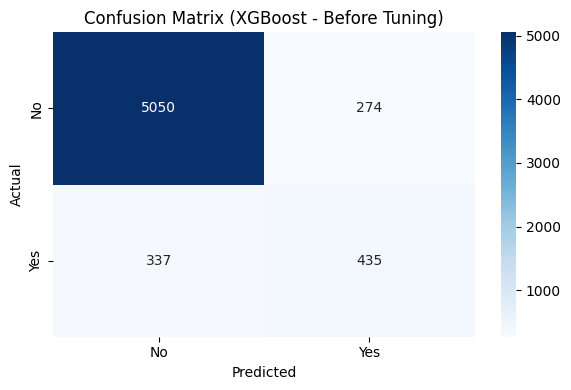


Classification Report (XGBoost - Before Tuning):
              precision    recall  f1-score   support

          No       0.94      0.95      0.94      5324
         Yes       0.61      0.56      0.59       772

    accuracy                           0.90      6096
   macro avg       0.78      0.76      0.77      6096
weighted avg       0.90      0.90      0.90      6096

Precision (XGBoost - Before Tuning): 0.6135
CVR (XGBoost - Before Tuning): 61.35%
ROMI (XGBoost - Before Tuning): 1233.78%


In [57]:
# Baseline XGBoost model (tanpa tuning)
xgb_base = XGBClassifier(random_state=42)

# Pipeline
baseline_xgb_pipeline = Pipeline([
    ("preprocessing", transformer),
    ("modeling", xgb_base)
])

# Fit
baseline_xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb_before = baseline_xgb_pipeline.predict(X_test)

# Confusion Matrix
cm_xgb_before = confusion_matrix(y_test, y_pred_xgb_before)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb_before, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost - Before Tuning)')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report (XGBoost - Before Tuning):")
print(classification_report(y_test, y_pred_xgb_before, target_names=['No', 'Yes']))

# Precision
precision_xgb_before = precision_score(y_test, y_pred_xgb_before)
print(f"Precision (XGBoost - Before Tuning): {precision_xgb_before:.4f}")

# Tambahan: CVR dan ROMI
cvr_xgb_before = calc_cvr(y_test, y_pred_xgb_before)
romi_xgb_before = calc_romi(y_test, y_pred_xgb_before)
print(f"CVR (XGBoost - Before Tuning): {cvr_xgb_before:.2f}%")
print(f"ROMI (XGBoost - Before Tuning): {romi_xgb_before:.2f}%")

Sebelum dilakukan hyperparameter tuning, model XGBoost menghasilkan precision sebesar 61.35% pada kelas target (Yes), dengan recall 56% dan f1-score 59%. Metrik bisnis menunjukkan bahwa model memiliki Conversion Rate (CVR) sebesar 61.35% dan Return on Marketing Investment (ROMI) mencapai 1233.78%, yang sudah cukup menjanjikan. Namun, untuk memaksimalkan precision serta efisiensi bisnis, dilakukan tahap tuning lebih lanjut.

In [58]:
# Model dasar
xgb_model = XGBClassifier(random_state=42)

# Pipeline
xgb_pipeline = Pipeline([
    ("preprocessing", transformer),
    ("modeling", xgb_model)
])

# Hyperparameter grid
hyperparam_xgb = {
    'modeling__n_estimators': [100, 200],
    'modeling__max_depth': [3, 5],
    'modeling__learning_rate': [0.01, 0.1],
    'modeling__subsample': [0.8, 1],
    'modeling__colsample_bytree': [0.8, 1]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=hyperparam_xgb,
    scoring='precision',
    n_jobs=-1,
    cv=cv_folds,
    verbose=1
)

# Fit
grid_search_xgb.fit(X_train, y_train)

# Model terbaik
best_xgb_model = grid_search_xgb.best_estimator_
print("\nBest Parameters Found (XGBoost):")
print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters Found (XGBoost):
{'modeling__colsample_bytree': 0.8, 'modeling__learning_rate': 0.01, 'modeling__max_depth': 3, 'modeling__n_estimators': 100, 'modeling__subsample': 0.8}


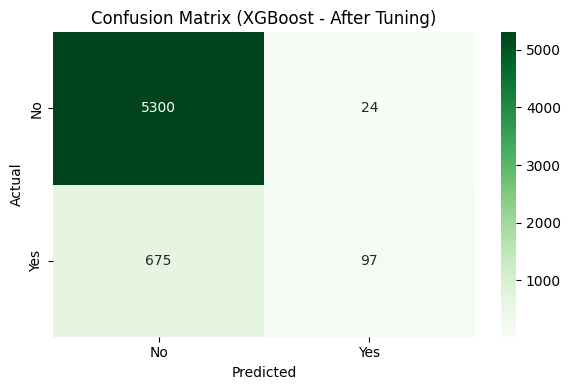


 Classification Report (XGBoost - After Tuning):
              precision    recall  f1-score   support

          No       0.89      1.00      0.94      5324
         Yes       0.80      0.13      0.22       772

    accuracy                           0.89      6096
   macro avg       0.84      0.56      0.58      6096
weighted avg       0.88      0.89      0.85      6096

Precision (XGBoost - After Tuning): 0.8017
CVR (XGBoost - After Tuning): 80.17%
ROMI (XGBoost - After Tuning): 1642.72%


In [59]:
# Prediksi
y_pred_xgb_after = best_xgb_model.predict(X_test)

# Confusion Matrix
cm_xgb_after = confusion_matrix(y_test, y_pred_xgb_after)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb_after, annot=True, fmt='d', cmap='Greens', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost - After Tuning)')
plt.tight_layout()
plt.show()

# Classification Report
print("\n Classification Report (XGBoost - After Tuning):")
print(classification_report(y_test, y_pred_xgb_after, target_names=['No', 'Yes']))

# Precision
precision_xgb_after = precision_score(y_test, y_pred_xgb_after)
print(f"Precision (XGBoost - After Tuning): {precision_xgb_after:.4f}")

cvr_xgb_after = calc_cvr(y_test, y_pred_xgb_after)
romi_xgb_after = calc_romi(y_test, y_pred_xgb_after)
print(f"CVR (XGBoost - After Tuning): {cvr_xgb_after:.2f}%")
print(f"ROMI (XGBoost - After Tuning): {romi_xgb_after:.2f}%")

Setelah dilakukan hyperparameter tuning, model XGBoost menunjukkan peningkatan signifikan pada metrik precision untuk kelas Yes, yaitu sebesar 80.17%. Walaupun recall menurun menjadi 13%, hal ini sesuai dengan fokus utama untuk memaksimalkan precision. Secara bisnis, hasil ini berdampak positif, dengan CVR meningkat menjadi 80.17% dan ROMI mencapai 1642.72%, yang menunjukkan efektivitas model dalam memilih prospek yang benar-benar potensial.

Berikut hasil before after Hyperparameter Tuning XGBoost

| Model          | Precision |   CVR   | ROMI  |
|----------------|-----------|---------|-------|
| Before Tuning  | 0.61      | 61.35   | 1233  |
| After Tuning   | 0.80      | 80.17   | 1642  |


### **Threshold Tuning**

Setelah model terbaik ditemukan melalui hyperparameter tuning, dilakukan proses lanjutan dengan threshold tuning untuk mengatur ambang batas probabilitas dalam klasifikasi, dengan tujuan memaksimalkan precision sesuai prioritas bisnis. Proses ini mengevaluasi performa model pada berbagai nilai threshold dan menghitung metrik seperti Precision, Recall, F1 Score, CVR, dan ROMI.


=== Threshold Evaluation with CVR & ROMI ===
    Threshold  Precision  Recall  F1_Score  CVR (%)  ROMI (%)
0        0.10     0.3558  0.9508    0.5178    35.58    673.46
1        0.15     0.4434  0.8873    0.5913    44.34    863.84
2        0.20     0.5098  0.8109    0.6260    50.98   1008.20
3        0.25     0.5460  0.7228    0.6221    54.60   1086.93
4        0.30     0.5822  0.6101    0.5958    58.22   1165.65
5        0.35     0.6402  0.3964    0.4896    64.02   1291.67
6        0.40     0.7093  0.2655    0.3864    70.93   1442.05
7        0.45     0.7622  0.1619    0.2671    76.22   1556.95
8        0.50     0.8017  0.1256    0.2172    80.17   1642.72
9        0.55     0.9259  0.0324    0.0626    92.59   1912.88
10       0.60     0.0000  0.0000    0.0000     0.00      0.00
11       0.65     0.0000  0.0000    0.0000     0.00      0.00
12       0.70     0.0000  0.0000    0.0000     0.00      0.00
13       0.75     0.0000  0.0000    0.0000     0.00      0.00
14       0.80     0.0000

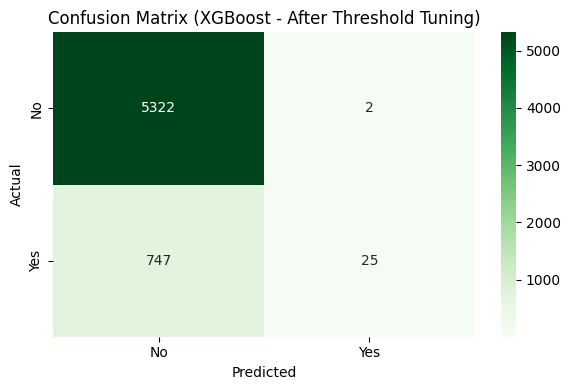

In [60]:
y_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Parameter bisnis
cost_per_customer = 23
revenue_per_success = 500

# Loop untuk berbagai threshold
thresholds = np.arange(0.1, 0.91, 0.05)
metrics_list = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # CVR: dari semua prediksi positif, berapa yang benar (true positive)
    tp = np.sum((y_test == 1) & (y_pred == 1))
    pred_pos = np.sum(y_pred == 1)
    cvr = (tp / pred_pos) * 100 if pred_pos > 0 else 0
    
    # ROMI: (Revenue - Cost) / Cost * 100
    total_revenue = tp * revenue_per_success
    total_cost = pred_pos * cost_per_customer
    romi = ((total_revenue - total_cost) / total_cost) * 100 if total_cost > 0 else 0

    metrics_list.append({
        'Threshold': t,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1_Score': round(f1, 4),
        'CVR (%)': round(cvr, 2),
        'ROMI (%)': round(romi, 2)
    })

# Hasil dalam DataFrame
df_threshold = pd.DataFrame(metrics_list)
print("\n=== Threshold Evaluation with CVR & ROMI ===")
print(df_threshold)

# Ambil threshold dengan Precision tertinggi
best_row = df_threshold.sort_values(by='Precision', ascending=False).iloc[0]
best_threshold = best_row['Threshold']
print(f"\n Best Threshold (Highest Precision): {best_threshold}")
print(best_row)

# Confusion Matrix akhir (di threshold terbaik)
y_pred_best = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_best)

# Visualisasi Confusion Matrix sebagai gambar
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost - After Threshold Tuning)')
plt.tight_layout()
plt.show()


Hasilnya menunjukkan bahwa menaikkan threshold ke 0.55 menghasilkan precision tertinggi (92.59%) dan secara signifikan meningkatkan efektivitas kampanye secara bisnis, terbukti dari nilai CVR dan ROMI yang juga meningkat tajam

### **Business Simulation**

**1. Skenario Tanpa Menggunakan Model**

Dalam skenario tanpa menggunakan model prediktif (misalnya seluruh pelanggan dihubungi tanpa seleksi), diperoleh hasil sebagai berikut:
- Total pelanggan yang melakukan deposit: 3,859 orang
- Conversion Rate (CVR): 12.65%
- Total pelanggan yang dihubungi: 30,488 orang
- Biaya per panggilan (telepon): €23
- Total biaya telepon: 30,488 × €23 = €701,224
- Total pendapatan dari konversi: 3,859 × €500 = €1,929,500
- Return on Marketing Investment (ROMI): 175.16%

**2. Skenario Menggunakan Model**

Setelah dilakukan pemodelan menggunakan XGBoost, kita dapat menghitung potensi pendapatan dan ROMI (Return on Marketing Investment) berdasarkan hasil prediksi terhadap data uji sebanyak 6,096 pelanggan.

Berdasarkan confusion matrix, diperoleh:

- TP (Prediksi: Ya, Aktual: Ya) = 97
- FP (Prediksi: Ya, Aktual: Tidak) = 24
- FN (Prediksi: Tidak, Aktual: Ya) = 675
- TN (Prediksi: Tidak, Aktual: Tidak) = 5,300

Kita hanya akan menghubungi pelanggan yang diprediksi akan melakukan deposit (TP + FP):

- Jumlah pelanggan yang dihubungi : 97 dari 121 orang           
- Jumlah yang benar-benar deposit (TP) : 97 orang                                  
- Conversion Rate (CVR) : 97 / 121 × 100 = 80.17%                  
- Total pendapatan (estimasi) : 97 × €500 = €48,500                       
- Total biaya telemarketing : 121 × €23 = €2,783                       
- ROMI : (48,500 - 2,783) / 2,783 × 100 = 1,743.5%

**3. Skenario Menggunakan Threshold**

Setelah melakukan penyesuaian threshold probabilitas pada model XGBoost, dilakukan evaluasi terhadap 6.096 data pelanggan. Tujuannya adalah untuk meningkatkan nilai precision agar kampanye lebih tepat sasaran dan biaya tidak terbuang percuma.

Berdasarkan confusion matrix, diperoleh:

- TP (Prediksi: Ya, Aktual: Ya) = 25
- FP (Prediksi: Ya, Aktual: Tidak) = 2
- FN (Prediksi: Tidak, Aktual: Ya) = 747
- TN (Prediksi: Tidak, Aktual: Tidak) = 5,322

Kita hanya akan menghubungi pelanggan yang diprediksi akan melakukan deposit (TP + FP):

- Jumlah pelanggan yang dihubungi : 25 dari 27 orang                    
- Jumlah yang benar-benar deposit (TP) : 25 orang                              
- Conversion Rate (CVR) : 25 / 27 × 100 = 92.59%              
- Total pendapatan (estimasi) : 25 × €500 = €12,500                  
- Total biaya telemarketing : 27 × €23 = €621                    
- ROMI : (12,500 - 621) / 621 × 100 = 1,913.0% 

**4. Perbandingan**

| Strategi                          | CVR    | ROMI     | Pelanggan Dihubungi |
| ----------------------------------| ------ | -------- | ------------------- |
| Tanpa Modeling                    | 12.65% | 175.16%  | 30,488              |
| Dengan Modeling (XGB)             | 80.17% | 1,743.5% | 97                  |
| Dengan Modeling (XGB) + Threshold | 92.59% | 1,913.0% | 27                  |

Setelah dilakukan perbandingan antara skenario tanpa modeling dan dengan modeling menggunakan algoritma XGBoost dengan threshold tuning, diperoleh hasil sebagai berikut:

- **Conversion Rate (CVR)** meningkat dari 12.65% (tanpa model) menjadi 92.59% (dengan model).
Artinya, tingkat keberhasilan dalam mengonversi prospek menjadi pelanggan meningkat lebih dari 7 kali lipat.
- **Return on Marketing Investment (ROMI)** meningkat dari 175.16% menjadi 1,913.0%.
Ini menunjukkan bahwa efektivitas biaya pemasaran meningkat hampir 11 kali lipat.

Dengan menggunakan model prediktif, perusahaan dapat menargetkan pelanggan yang lebih tepat, sehingga mengurangi pemborosan biaya panggilan dan secara signifikan meningkatkan keuntungan dari setiap investasi pemasaran yang dilakukan.


## **Save Model**

In [ ]:
import pickle

# Simpan model ke file
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

# Simpan threshold terbaik juga (jika ada threshold tuning)
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)


## **Kesimpulan dan Rekomendasi**

**Kesimpulan**

Melalui proses pemodelan menyeluruh menggunakan teknik data cleaning, feature engineering, preprocessing, serta evaluasi terhadap berbagai model machine learning, kami menemukan bahwa XGBoost Classifier dengan penyesuaian threshold merupakan model terbaik untuk kasus prediksi pelanggan potensial deposito berjangka.

Evaluasi terhadap data uji menunjukkan bahwa model ini:

- Mampu mencapai precision yang sangat tinggi (92.59%), artinya hampir seluruh pelanggan yang diprediksi akan melakukan deposit benar-benar melakukannya.
- Hanya perlu menghubungi 27 pelanggan saja, dibandingkan 30,488 jika tanpa model efisiensi yang sangat signifikan.
- Menghasilkan Conversion Rate (CVR) sebesar 92.59%, meningkat lebih dari 7 kali lipat dibandingkan tanpa model.
- Meningkatkan Return on Marketing Investment (ROMI) menjadi 1,913%, atau hampir 11 kali lipat lebih besar dari strategi pemasaran konvensional.

Dengan pemanfaatan machine learning untuk prediksi pelanggan, perusahaan dapat menjalankan campaign yang jauh lebih efisien dan tepat sasaran. Model ini dapat memaksimalkan keuntungan, meminimalkan biaya pemasaran yang sia-sia, serta meningkatkan efektivitas strategi bisnis secara keseluruhan.



**Rekomendasi untuk Manajemen Pemasaran**

**1. Prioritaskan Pelanggan Berdasarkan Prediksi Model**

Fokuskan upaya telemarketing pada pelanggan yang diprediksi memiliki kemungkinan tinggi untuk melakukan deposit, berdasarkan hasil dari model XGBoost. Strategi ini terbukti meningkatkan Conversion Rate dari 12.65% menjadi 92.59%, dan ROMI dari 175.16% menjadi 1,913%.

**2. Terapkan Threshold Probabilitas Tinggi dalam Eksekusi Campaign**

Gunakan ambang probabilitas (threshold) tinggi untuk menyaring pelanggan yang akan dihubungi. Ini meminimalkan pemborosan biaya pada calon yang tidak tertarik, dan memastikan bahwa setiap panggilan memiliki potensi konversi yang tinggi.

**3. Realokasi Anggaran Marketing Secara Lebih Efisien**

Kurangi jumlah total pelanggan yang dihubungi, dan alokasikan kembali anggaran tersebut untuk intensifikasi kontak pada target yang tepat atau untuk memperluas cakupan promosi bagi pelanggan berkualitas tinggi.

**4. Integrasikan Output Model dengan Tim Telemarketing**

Sediakan hasil prediksi dalam format yang mudah dipahami oleh tim sales atau call center (misalnya daftar pelanggan harian atau mingguan dengan skor probabilitas), sehingga proses campaign menjadi lebih terarah dan cepat dijalankan.



**Rekomendasi Strategis untuk Keberlanjutan Model & Pemanfaatannya**

**1. Perbarui Model Secara Berkala Berdasarkan Data Terbaru**

Untuk menjaga akurasi dan relevansi prediksi, disarankan melakukan pelatihan ulang model secara berkala (misalnya setiap kuartal), menyesuaikan dengan dinamika perilaku pelanggan dan perubahan strategi kampanye.

**2. Perkaya Data Input dengan Sumber Informasi Tambahan**

Menambahkan variabel baru seperti riwayat interaksi campaign sebelumnya, frekuensi kontak, atau channel komunikasi yang digunakan berpotensi meningkatkan kemampuan model dalam membedakan pelanggan yang potensial melakukan deposit.

**3. Kembangkan Dashboard Monitoring Model untuk Tim Marketing**

Dengan menyediakan visualisasi performa seperti Precision, Conversion Rate (CVR), dan ROMI, tim marketing dapat memantau efektivitas model secara real-time dan merespons dengan cepat jika terjadi penurunan performa.

**3. Uji Threshold yang Berbeda untuk Menyesuaikan Tujuan Kampanye**

Gunakan pendekatan A/B Testing untuk mencoba berbagai nilai ambang probabilitas (threshold) guna menyesuaikan antara efisiensi biaya dan jangkauan target pelanggan. Hasilnya bisa digunakan sebagai dasar penyesuaian strategi kampanye berikutnya.

**4. Pantau Perubahan Pola Data (Data Drift)**

Secara rutin lakukan monitoring terhadap distribusi data input dan output model. Jika terdapat pergeseran yang signifikan, segera evaluasi kembali performa prediksi dan lakukan pelatihan ulang bila diperlukan.

